In [159]:
import random, shutil
import torch
import torch.nn as nn
from tqdm.notebook import tqdm
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import numpy as np
from torch.utils.data import random_split,Dataset,DataLoader
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import time

from google.colab import drive

In [160]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [161]:
dataset = ImageFolder('/content/drive/MyDrive/praca_inzynierska/data/images_original/')

In [162]:
len(dataset)

1009

In [163]:
genres = []
for i in dataset.classes:
  genres.append(i)
genres

['blues',
 'classical',
 'country',
 'disco',
 'hiphop',
 'jazz',
 'metal',
 'pop',
 'reggae',
 'rock']

In [164]:
random_seed = 42
torch.manual_seed(random_seed);

In [165]:
test_pct = 0.2
test_size = int(len(dataset)*test_pct)
dataset_size = len(dataset) - test_size

val_pct = 0.1
val_size = int(len(dataset)*val_pct)
train_size = dataset_size - val_size
train_size,test_size,val_size

(708, 201, 100)

In [166]:
train_ds,test_ds,val_ds = random_split(dataset,[train_size,test_size,val_size])
len(train_ds),len(test_ds),len(val_ds)

(708, 201, 100)

jazz
<class 'PIL.Image.Image'>


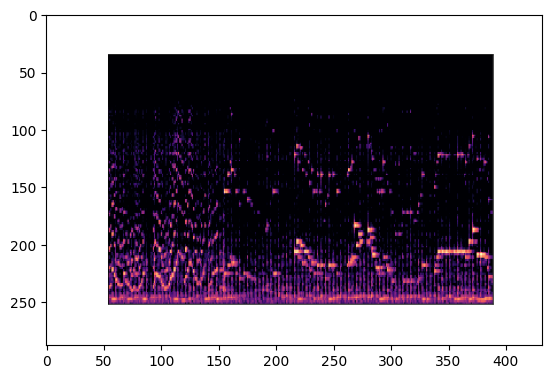

In [167]:
img,label = train_ds[2]
print(dataset.classes[label])
plt.imshow(img)
print(type(img))

In [168]:
class MusicGenreDataset(Dataset):
  def __init__(self,ds,transform=None):
    self.ds = ds
    self.transform = transform

  def __len__(self):
    return len(self.ds)

  def __getitem__(self,idx):
    img,label = self.ds[idx]
    if self.transform:
      img = self.transform(img)
      return img,label

In [169]:
train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    # transforms.RandomCrop(224, padding=4,padding_mode='reflect'),
    # transforms.RandomHorizontalFlip(p=0.3),
    # transforms.RandomRotation(degrees=30),
    # transforms.GaussianBlur(kernel_size = 7,sigma = (0.1, 2.0)),
    # transforms.ElasticTransform(alpha=50.0),
    transforms.ToTensor()
])

val_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

In [170]:
train_dataset = MusicGenreDataset(train_ds,train_transform)
val_dataset = MusicGenreDataset(val_ds,val_transform)
test_dataset = MusicGenreDataset(test_ds,test_transform)

0


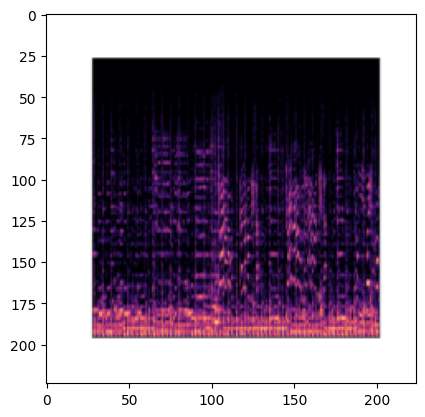

In [171]:
img, label = train_dataset[10]
print(label)
plt.imshow(img.permute(1,2,0))

In [172]:
batch_size = 16
train_dl = DataLoader(train_dataset,batch_size,shuffle=True,num_workers=2,pin_memory=True)
test_dl = DataLoader(test_dataset,batch_size*2,num_workers=2,pin_memory=True)
val_dl = DataLoader(val_dataset,batch_size*2,num_workers=2,pin_memory=True)

In [173]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [174]:
class ImageClassificationBase(nn.Module):
    # training step
    def training_step(self, batch):
        img, targets = batch
        out = self(img)
        loss = F.nll_loss(out, targets)
        return loss

    # validation step
    def validation_step(self, batch):
        img, targets = batch
        out = self(img)
        loss = F.nll_loss(out, targets)
        acc = accuracy(out, targets)
        return {'val_acc':acc.detach(), 'val_loss':loss.detach()}

    # validation epoch end
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss':epoch_loss.item(), 'val_acc':epoch_acc.item()}

    # print result end epoch
    def epoch_end(self, epoch, result):
        print("Epoch [{}] : train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result["train_loss"], result["val_loss"], result["val_acc"]))


In [175]:
class MusicGenreClassificationCNN(ImageClassificationBase):
    def __init__(self):
        super().__init__()

        self.network = nn.Sequential(
            nn.Conv2d(3, 8, 3, stride=1, padding=1),   # 224 * 244 * 32
            nn.BatchNorm2d(num_features=8),
            nn.ReLU(),

            nn.Conv2d(8, 16, 3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                         # 112 * 112 * 32

            nn.Conv2d(16, 32, 3, stride=1, padding=1),   # 112 * 112* 64
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),

            nn.Conv2d(32, 64, 3, stride=1, padding=1),    # 112 * 112* 128
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.MaxPool2d(2,2),                          # 56 * 56* 128

            nn.Conv2d(64, 128, 3, stride=1, padding=1),   # 56*56*256
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),

            nn.Conv2d(128, 256, 3, stride=1, padding=1),  # 56*56*256
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),
            nn.MaxPool2d(2,2),                        # 28*28*256

            nn.Conv2d(256, 256, 3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),
            nn.MaxPool2d(2,2),                            # 14*14*256

            nn.Conv2d(256, 256, 3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),
            nn.MaxPool2d(2,2),                            # 7*7*256

            nn.Flatten(),
            nn.Linear(7*7*256, 512),
            nn.ReLU(),
            nn.Linear(512, 120),
            nn.Dropout(p=0.3, inplace=False),
            nn.LogSoftmax(dim = 1),

        )

    def forward(self, xb):
        return self.network(xb)

In [176]:
model = MusicGenreClassificationCNN()
model

MusicGenreClassificationCNN(
  (network): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1

In [177]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(d, device) for d in data]
    else:
        return data.to(device, non_blocking=True)

In [178]:
class DeviceDataLoader:
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        for batch in self.dl:
            yield to_device(batch, self.device)

In [179]:
# getting default device
device = get_default_device()
print(device)

# moving train dataloader and val dataloader to gpu
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)


# moving model to gpu
to_device(model, device);

cuda


In [180]:
def proc_time(b_sz, model, n_iter=10):
    x = torch.rand(b_sz, 3, 224, 224).cuda()
    torch.cuda.synchronize()
    start = time.time()
    for _ in range(n_iter):
        model(x)
    torch.cuda.synchronize()
    end = time.time() - start
    throughput = b_sz * n_iter / end
    print(f"Batch: {b_sz} \t {throughput} samples/sec")
    return (b_sz, throughput, )

In [181]:
proc_time(16,model)

Batch: 16 	 609.606197359146 samples/sec


(16, 609.606197359146)

In [182]:
# check the model
def try_batch(dl):
    for imgs, labels in dl:
        print("images shape : ", imgs.shape)
        print("labels : ", labels)
        outs = model(imgs)                          # Change model object here
        print("outs.shape :", outs.shape)
        print("outs : ", outs)
        break

try_batch(train_dl)

images shape :  torch.Size([16, 3, 224, 224])
labels :  tensor([8, 4, 3, 5, 6, 0, 2, 5, 6, 1, 6, 1, 8, 9, 5, 3], device='cuda:0')
outs.shape : torch.Size([16, 120])
outs :  tensor([[-4.8177, -4.3259, -5.3798,  ..., -4.5613, -4.7227, -4.9155],
        [-4.8511, -4.4240, -5.5931,  ..., -4.8011, -4.8357, -5.3373],
        [-4.7099, -4.6132, -4.8352,  ..., -4.7123, -4.9105, -4.8352],
        ...,
        [-4.7811, -4.7811, -5.3438,  ..., -4.7289, -4.7811, -5.0192],
        [-4.3886, -4.6712, -5.4875,  ..., -4.5906, -4.5870, -5.1154],
        [-4.6041, -4.7385, -5.4631,  ..., -4.8134, -4.8134, -5.2025]],
       device='cuda:0', grad_fn=<LogSoftmaxBackward0>)


In [183]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']


def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, weight_decay=0, grad_clip=None, opt_func = torch.optim.Adam):
    torch.cuda.empty_cache()
    history = []
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # set up one cycle lr scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))

    for epoch in range(epochs):

        # Training phase
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)

            # calculates gradients
            loss.backward()

            # check gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            # perform gradient descent and modifies the weights
            optimizer.step()

            # reset the gradients
            optimizer.zero_grad()

            # record and update lr
            lrs.append(get_lr(optimizer))

            # modifies the lr value
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)


    return history



@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

In [184]:
evaluate(model, val_dl)

{'val_loss': 4.742913722991943, 'val_acc': 0.0}

In [185]:
num_epochs = 50
opt_func = torch.optim.SGD

max_lr = 0.001
grad_clip = 0.1
weight_decay = 1e-4

In [186]:
history = fit_one_cycle(num_epochs, max_lr, model, train_dl, val_dl, weight_decay, grad_clip, opt_func)

  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [0] : train_loss: 3.8939, val_loss: 3.1848, val_acc: 0.2344


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [1] : train_loss: 3.1896, val_loss: 2.7236, val_acc: 0.2734


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [2] : train_loss: 2.7943, val_loss: 2.1808, val_acc: 0.4062


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [3] : train_loss: 2.6237, val_loss: 1.9653, val_acc: 0.4297


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [4] : train_loss: 2.4322, val_loss: 1.9243, val_acc: 0.5000


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [5] : train_loss: 2.3719, val_loss: 1.6473, val_acc: 0.5156


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [6] : train_loss: 2.2686, val_loss: 1.9816, val_acc: 0.3438


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [7] : train_loss: 2.2972, val_loss: 1.8712, val_acc: 0.5078


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [8] : train_loss: 2.1061, val_loss: 1.8363, val_acc: 0.3516


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [9] : train_loss: 1.9244, val_loss: 1.8822, val_acc: 0.3984


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [10] : train_loss: 1.9376, val_loss: 1.0841, val_acc: 0.7031


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [11] : train_loss: 1.7454, val_loss: 1.5618, val_acc: 0.5078


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [12] : train_loss: 1.5561, val_loss: 1.2604, val_acc: 0.6406


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [13] : train_loss: 1.4561, val_loss: 1.3460, val_acc: 0.6328


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [14] : train_loss: 1.3406, val_loss: 1.5370, val_acc: 0.4609


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [15] : train_loss: 1.3200, val_loss: 1.3288, val_acc: 0.5859


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [16] : train_loss: 1.2769, val_loss: 1.4034, val_acc: 0.5703


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [17] : train_loss: 1.1397, val_loss: 0.9998, val_acc: 0.7656


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [18] : train_loss: 1.1689, val_loss: 1.1656, val_acc: 0.5938


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [19] : train_loss: 1.0966, val_loss: 0.9166, val_acc: 0.7344


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [20] : train_loss: 1.1843, val_loss: 0.9097, val_acc: 0.7109


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [21] : train_loss: 1.0023, val_loss: 0.9594, val_acc: 0.6719


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [22] : train_loss: 1.1076, val_loss: 0.9116, val_acc: 0.7812


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [23] : train_loss: 1.1124, val_loss: 0.9029, val_acc: 0.7266


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [24] : train_loss: 1.1119, val_loss: 0.8292, val_acc: 0.7969


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [25] : train_loss: 1.0936, val_loss: 0.8790, val_acc: 0.7500


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [26] : train_loss: 1.0893, val_loss: 0.8007, val_acc: 0.7266


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [27] : train_loss: 1.0621, val_loss: 0.8758, val_acc: 0.7500


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [28] : train_loss: 0.9807, val_loss: 0.8210, val_acc: 0.7109


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [29] : train_loss: 1.1247, val_loss: 0.8621, val_acc: 0.6641


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [30] : train_loss: 1.0967, val_loss: 0.8674, val_acc: 0.6719


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [31] : train_loss: 1.0759, val_loss: 0.8712, val_acc: 0.6719


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [32] : train_loss: 1.0467, val_loss: 0.8712, val_acc: 0.7422


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [33] : train_loss: 1.0852, val_loss: 0.8056, val_acc: 0.7266


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [34] : train_loss: 1.2422, val_loss: 0.8676, val_acc: 0.6875


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [35] : train_loss: 1.0770, val_loss: 0.8861, val_acc: 0.7422


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [36] : train_loss: 1.1165, val_loss: 0.8556, val_acc: 0.7422


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [37] : train_loss: 1.1420, val_loss: 0.8523, val_acc: 0.6797


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [38] : train_loss: 0.9607, val_loss: 0.8268, val_acc: 0.6719


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [39] : train_loss: 0.9790, val_loss: 0.8355, val_acc: 0.7422


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [40] : train_loss: 1.1080, val_loss: 0.8297, val_acc: 0.7422


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [41] : train_loss: 0.9383, val_loss: 0.8666, val_acc: 0.6875


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [42] : train_loss: 1.1163, val_loss: 0.8690, val_acc: 0.6797


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [43] : train_loss: 1.1222, val_loss: 0.8572, val_acc: 0.6875


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [44] : train_loss: 1.0617, val_loss: 0.8540, val_acc: 0.7422


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [45] : train_loss: 1.0415, val_loss: 0.8760, val_acc: 0.6797


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [46] : train_loss: 1.1685, val_loss: 0.8676, val_acc: 0.7344


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [47] : train_loss: 1.0358, val_loss: 0.8614, val_acc: 0.7344


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [48] : train_loss: 1.0451, val_loss: 0.8631, val_acc: 0.6797


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [49] : train_loss: 0.9845, val_loss: 0.8607, val_acc: 0.7422
